In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec 
import itertools    
import pickle

from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

%matplotlib inline

In [0]:
def getTokens(input):
    tokensBySlash = str(input.encode('utf-8')).split('/')
    allTokens = []
    for i in tokensBySlash:
        tokens = str(i).split('-')
        tokensByDot = []
        for j in range(0,len(tokens)):
            tempTokens = str(tokens[j]).split('.')
            tokensByDot = tokensByDot + tempTokens
        allTokens = allTokens + tokens + tokensByDot
    allTokens = list(set(allTokens))
    if 'com' in allTokens:
        allTokens.remove('com')
    return allTokens

def trim(url):
    return re.match(r'(?:\w*://)?(?:.*\.)?([a-zA-Z-1-9]*\.[a-zA-Z]{1,}).*', url).groups()[0]

def sanitization(web):                   
  web = web.lower()
  token = []
  dot_token_slash = []
  raw_slash = str(web).split('/')
  for i in raw_slash:
      raw1 = str(i).split('-')            # removing slash to get token
      slash_token = []
      for j in range(0,len(raw1)):
          raw2 = str(raw1[j]).split('.')  # removing dot to get the tokens
          slash_token = slash_token + raw2
      dot_token_slash = dot_token_slash + raw1 + slash_token # all tokens
  token = list(set(dot_token_slash))      # to remove same words  
  if 'com' in token:
      token.remove('com')                 # remove com
  return token

def makeTokens(f):
    tkns_BySlash = str(f.encode('utf-8')).split('/')	# make tokens after splitting by slash
    total_Tokens = []
    for i in tkns_BySlash:
        tokens = str(i).split('-')	# make tokens after splitting by dash
        tkns_ByDot = []
        for j in range(0,len(tokens)):
            temp_Tokens = str(tokens[j]).split('.')	# make tokens after splitting by dot
            tkns_ByDot = tkns_ByDot + temp_Tokens
        total_Tokens = total_Tokens + tokens + tkns_ByDot
    total_Tokens = list(set(total_Tokens))	#remove redundant tokens
    if 'com' in total_Tokens:
        total_Tokens.remove('com')	#removing .com since it occurs a lot of times and it should not be included in our features
    return total_Tokens

In [0]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [0]:
def get_max(data):
  result = list()
  for _data in data:
    result.append(np.argmax(_data))
  return np.array(result)

In [0]:
# evaluation functions for different models

def lgb_f1_score(preds, train_data):
    y_train = train_data.get_label()
    preds = (preds >= 0.5).astype(int)
    return 'f1_score', f1_score(y_train, preds), True

def xgb_f1_score(preds, train_data):
    y_train = train_data.get_label()
    preds = (preds >= 0.5).astype(int)
    return 'f1_score', f1_score(y_train, preds)

In [0]:
data = pd.read_csv("/content/url-dataset.csv", encoding = 'latin-1')

y = data['label']
corpus = data['url']
vectorizer = TfidfVectorizer(tokenizer=makeTokens)
X = vectorizer.fit_transform(corpus)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       731
           1       1.00      1.00      1.00       781

    accuracy                           1.00      1512
   macro avg       1.00      1.00      1.00      1512
weighted avg       1.00      1.00      1.00      1512



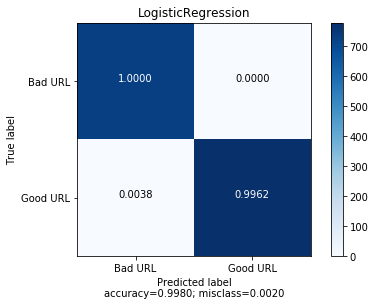

In [212]:
logreg_model = LogisticRegression()	
logreg_model.fit(X_train, y_train)
y_pred = logreg_model.predict(X_test)
classification = classification_report(y_test, y_pred, digits=2)
print(classification)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['Bad URL','Good URL'], title = 'LogisticRegression')
with open('logreg_model.pkl','wb') as file_out:
  pickle.dump(logreg_model,file_out)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       731
           1       1.00      1.00      1.00       781

    accuracy                           1.00      1512
   macro avg       1.00      1.00      1.00      1512
weighted avg       1.00      1.00      1.00      1512



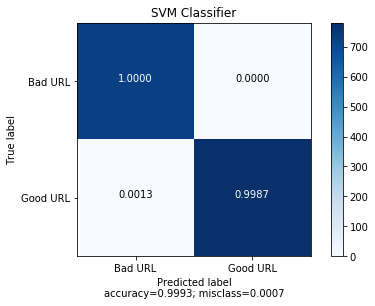

In [213]:
svd = TruncatedSVD(n_components = 15)
svd.fit(vstack((X_train, X_test)).tocsr())
x_train_svd = svd.transform(X_train)
x_dev_svd = svd.transform(X_test)

# scaling the data obtained from SVD
scaler = StandardScaler()
scaler.fit(np.concatenate((x_train_svd, x_dev_svd)))
x_train_svd = scaler.transform(x_train_svd)
x_dev_svd = scaler.transform(x_dev_svd)

svc_model = SVC(C = 0.1, probability = True)
svc_model.fit(x_train_svd, y_train)

y_pred = svc_model.predict(x_dev_svd)
classification = classification_report(y_test, y_pred, digits=2)
print(classification)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['Bad URL','Good URL'], title = 'SVM Classifier')
with open('svc_model.pkl','wb') as file_out:
  pickle.dump(svc_model,file_out)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       731
           1       1.00      0.98      0.99       781

    accuracy                           0.99      1512
   macro avg       0.99      0.99      0.99      1512
weighted avg       0.99      0.99      0.99      1512



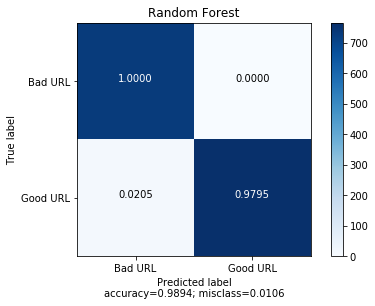

In [214]:
rf_model = RandomForestClassifier(max_depth=12, random_state=0)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
classification = classification_report(y_test, y_pred, digits=2)
print(classification)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['Bad URL','Good URL'], title = 'Random Forest')
with open('rf_model.pkl','wb') as file_out:
  pickle.dump(rf_model,file_out)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       731
           1       1.00      1.00      1.00       781

    accuracy                           1.00      1512
   macro avg       1.00      1.00      1.00      1512
weighted avg       1.00      1.00      1.00      1512



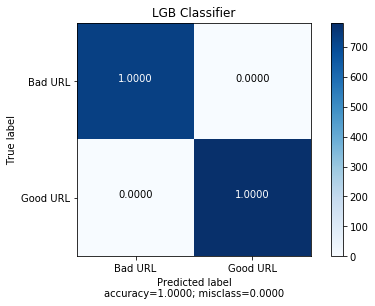

In [215]:
d_train = lgb.Dataset(X_train, label = y_train)
d_dev = lgb.Dataset(X_test, label = y_test)
valid_sets = [d_train, d_dev]

params = {'learning_rate': 0.2,
          'application': 'binary',
          'num_leaves': 31,
          'verbosity': -1,
          'bagging_fraction': 0.8,
          'feature_fraction': 0.6,
          'nthread': 4,
          'lambda_l1': 1,
          'lambda_l2': 1}

lgb_model = lgb.train(params,
                  train_set = d_train,
                  num_boost_round = 25,
                  valid_sets = valid_sets,
                  feval = lgb_f1_score,
                  verbose_eval = False)

lgb_dev_pred = lgb_model.predict(X_test)
y_pred = (lgb_dev_pred >= 0.5).astype(int)
classification = classification_report(y_test, y_pred, digits=2)
print(classification)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['Bad URL','Good URL'], title = 'LGB Classifier')
with open('lgb_model.pkl','wb') as file_out:
  pickle.dump(lgb_model,file_out)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       731
           1       1.00      1.00      1.00       781

    accuracy                           1.00      1512
   macro avg       1.00      1.00      1.00      1512
weighted avg       1.00      1.00      1.00      1512



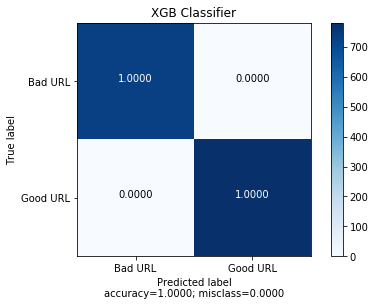

In [216]:
d_train = xgb.DMatrix(X_train, label = y_train)
d_dev = xgb.DMatrix(X_test, label = y_test)
evallist = [(d_train, 'train'), (d_dev, 'valid')]

params = {'booster' : 'gbtree',
          'nthread' : 4,
          'eta' : 0.2,
          'max_depth' : 6,
          'min_child_weight' : 4,
          'subsample' : 0.7,
          'colsample_bytree' : 0.7,
          'objective' : 'binary:logistic'}

xgb_model = xgb.train(params, 
                  d_train, 
                  num_boost_round = 21,
                  evals = evallist,
                  feval = xgb_f1_score,
                  verbose_eval = False)

xgb_dev_pred = xgb_model.predict(d_dev, ntree_limit = 21)
y_pred = (xgb_dev_pred >= 0.5).astype(int)
classification = classification_report(y_test, y_pred, digits=2)
print(classification)
cm = confusion_matrix(y_test, y_pred)
  plot_confusion_matrix(cm, ['Bad URL','Good URL'], title = 'XGB Classifier')
  with open('xgb_model.pkl','wb') as file_out:
    pickle.dump(xgb_model,file_out)

In [219]:
X_predict = ["google.com/search=jcharistech","google.com/search=faizanahmad","pakistanifacebookforever.com/getpassword.php/", "www.radsport-voggel.de/wp-admin/includes/log.exe", 
"ahrenhei.without-transfer.ru/nethost.exe ","www.itidea.it/centroesteticosothys/img/_notes/gum.exe"]
a = vectorizer.transform(X_predict)

logreg_model.predict_proba(a)

array([0.96863125, 0.03136875])